In [1]:
import sys, h5py, pdb,time, glob
from importlib import reload
import pylab as pl, numpy as np
from numpy import log10 as log
from astropy import units as un, constants as cons
import scipy, scipy.stats
from matplotlib import ticker
sys.path.append('../pysrc')

In [2]:
import FIRE_files as ff
from FIRE_files import cosmo, u
from projectPlotBasics import *
import first_pass as l
cmap = pl.get_cmap('viridis')

Behroozi+18 not loaded
don't have phil's colormaps


In [3]:
CF_path = '../../cooling_flow/pysrc'
sys.path.append(CF_path)
import cooling_flow as CF, HaloPotential as Halo
%matplotlib inline

In [4]:
# simname = 'vc200_Rs0_Mdot4847_Rcirc10_fgas02_res1e4_simpleSFthreshold10'
simname = 'tracking'
vc = 200. #float(simname.split('_')[0][2:])
Rcirc = 10.# float(simname.split('_')[3][5:])
# simdir = '/projects/b1026/jonathan/my_gizmo/%s/output/'%simname
simdir = '/projects/b1026/jonathan/KY_sims/sim_outputs/%s/output/'%simname

In [5]:
sim = l.KY_sim(simname,simdir,200*un.kpc,origin=np.zeros(3),Rcirc = 10*un.kpc,snapshot_dt_Myr=10,pr=False,
              analyticGravity= Halo.PowerLaw(m=0.,vc_Rvir=vc*un.km/un.s,Rvir=200*un.kpc))
print(sim.galaxyname, sim.Nsnapshots())


tracking 212


In [15]:
snapshots = [sim.getSnapshot(i) for i in range(100,200,1)][::-1]
ts = 2000-np.arange(len(snapshots))*10

In [16]:
qs = [snapshot.dic[('PartType0','ParticleIDs')] for snapshot in snapshots]

In [29]:
Rs_func = lambda s: (s.coords()[:,:2]**2).sum(axis=1)**0.5

In [20]:
# select by accretion time
_,inds1,inds2 = np.intersect1d(qs[0],qs[1],assume_unique=True,return_indices=True)
accreted_inds = (  ((Rs_func(snapshots[0])<10) & (np.abs(snapshots[0].coords()[:,2])<1))[inds1] &
                 (~((Rs_func(snapshots[1])<10) & (np.abs(snapshots[1].coords()[:,2]<1)))[inds2]) )
accreted_IDs = qs[0][inds1][accreted_inds]

In [205]:
# select by location in CGM
_,inds1,inds2 = np.intersect1d(qs[0],qs[-1],assume_unique=True,return_indices=True)
accreted_inds = ((snapshots[-1].rs()<26) & (snapshots[-1].rs()>25))[inds2]
accreted_IDs = qs[0][inds1][accreted_inds]

In [206]:
print(len(accreted_IDs.nonzero()[0]))
accreted_inds_dic = [None] * len(qs)
for iq,q in enumerate(qs):
    _,_,indices = np.intersect1d(accreted_IDs,q,assume_unique=True,return_indices=True)
    accreted_inds_dic[iq] = indices

13205


In [207]:
coords = np.array([snapshots[i].coords()[accreted_inds_dic[i],:] for i in range(len(snapshots))])
vs     = np.array([snapshots[i].vs()[accreted_inds_dic[i],:]     for i in range(len(snapshots))])
Ts     = np.array([snapshots[i].Ts()[accreted_inds_dic[i]]       for i in range(len(snapshots))])
nHs    = np.array([snapshots[i].nHs()[accreted_inds_dic[i]]      for i in range(len(snapshots))])

In [208]:
mu = 0.62
epsilons = Ts / (un.km**2/un.s**2 * cons.m_p / cons.k_B).to('K').value / (2./3* mu) 
cs = (epsilons*10/9)**0.5 
nHTs = nHs*Ts
Ks = Ts/nHs**(2/3.)

In [209]:
xs,ys,zs = coords[:,:,0],coords[:,:,1],coords[:,:,2]
rs    = (xs**2+ys**2+zs**2)**0.5
Rs    = (xs**2+ys**2)**0.5
phis  = np.arctan2(ys,xs)
thetas = np.arcsin(Rs/rs)

In [210]:
js = np.array([coords[:,:,1] * vs[:,:,2] - coords[:,:,2] * vs[:,:,1],
               coords[:,:,2] * vs[:,:,0] - coords[:,:,0] * vs[:,:,2],
               coords[:,:,0] * vs[:,:,1] - coords[:,:,1] * vs[:,:,0]])
js = np.moveaxis(js,[0,1],[2,0])
jzs = js[:,:,2]

In [211]:
vphis = jzs/Rs
vzs = vs[:,:,2]
vRs = (vs[:,:,0]*xs/rs + vs[:,:,1]*ys/rs)
vrs = (vs[:,:,0]*xs/rs + vs[:,:,1]*ys/rs + vs[:,:,2]*zs/rs)
# cos𝜃cos𝜙𝐱+cos𝜃sin𝜙𝐲−sin𝜃𝐳)𝜃
vthetas = vs[:,:,0]*np.cos(thetas)*np.cos(phis) + vs[:,:,1]*np.cos(thetas)*np.sin(phis) - vs[:,:,2]*np.sin(thetas)

In [212]:
bins = np.linspace(0,np.pi/2,11)
midbins = (bins[1:]+bins[:-1])/2
hist,_,theta_inds = scipy.stats.binned_statistic(thetas[-10:,:].mean(axis=0),values=None,
                                        statistic='count',bins=bins)
hist 

array([   6.,   37.,  100.,  244.,  647., 1361., 2085., 2617., 2985.,
       3123.])

In [218]:
theta_inds_to_show=np.array([1,4,7,10])
colors = pl.get_cmap('viridis')(1-np.arange(4)/3)

labels = [r'$\theta_\infty=%.1f\pi$'%m for m in midbins[theta_inds_to_show-1]/np.pi]
def med_and_std(all_vals,xs=ts,theta_inds=theta_inds):
    for i,ind in enumerate(theta_inds_to_show):
        vals = all_vals[:,theta_inds==ind]
        ys16,ys50,ys84 = [np.percentile(vals,p,axis=1) for p in (16,50,84)]
        pl.plot(xs,ys50,label=labels[i],c=colors[i])
        pl.fill_between(xs,ys16,ys84,facecolor=colors[i],alpha=0.1)    

Text(0.5, 0, 'time [Gyr]')

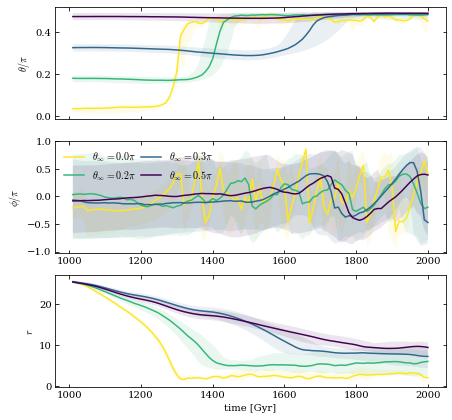

In [219]:
pl.figure(figsize=(7,7))
ax = pl.subplot(311)
med_and_std(thetas/np.pi)
pl.ylabel(r'$\theta/\pi$')
ax.xaxis.set_major_formatter(ticker.NullFormatter())
pl.subplot(312)
med_and_std(phis/np.pi)
pl.ylabel(r'$\phi/\pi$')
pl.legend(loc='upper left',ncol=2,frameon=False,columnspacing=0.5)
ax.xaxis.set_major_formatter(ticker.NullFormatter())
pl.subplot(313)
med_and_std(rs)
pl.ylabel(r'$r$')
pl.xlabel(r'time [Gyr]')

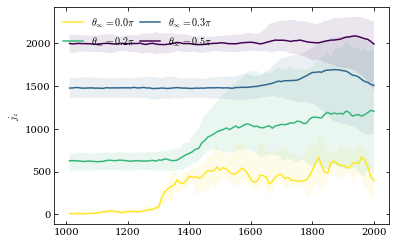

In [220]:
med_and_std(jzs)
pl.ylabel(r'$j_z$')
pl.legend(loc='upper left',ncol=2,frameon=False,columnspacing=0.5)

Text(0.5, 0, 'time [Gyr]')

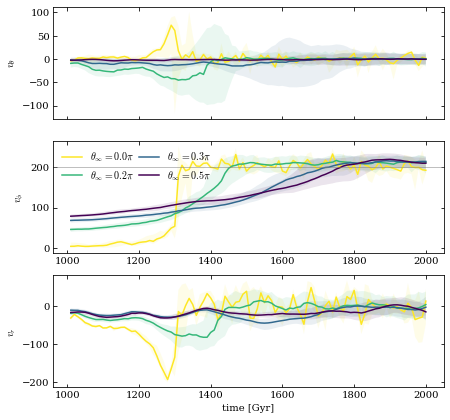

In [221]:
pl.figure(figsize=(7,7))
ax = pl.subplot(311)
med_and_std(vthetas)
pl.ylabel(r'$v_\theta$')
ax.xaxis.set_major_formatter(ticker.NullFormatter())
pl.subplot(312)
med_and_std(vphis)
pl.ylabel(r'$v_\phi$')
pl.legend(loc='upper left',ncol=2,frameon=False,columnspacing=0.5)
ax.xaxis.set_major_formatter(ticker.NullFormatter())
pl.axhline(200,c='.5',lw=0.5)
pl.subplot(313)
med_and_std(vrs)
pl.ylabel(r'$v_r$')
pl.xlabel(r'time [Gyr]')

Text(0.5, 0, 'time [Gyr]')

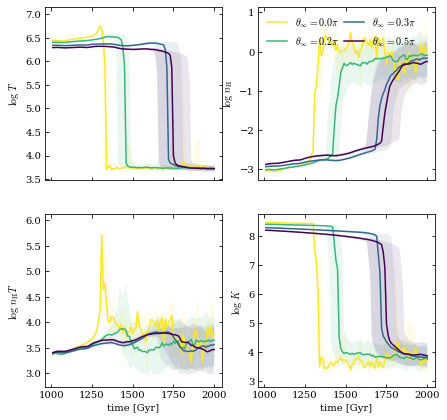

In [222]:
pl.figure(figsize=(7,7))
ax = pl.subplot(221)
med_and_std(log(Ts))
pl.ylabel(r'$\log\ T$')
ax.xaxis.set_major_formatter(ticker.NullFormatter())
ax = pl.subplot(222)
med_and_std(log(nHs))
pl.ylabel(r'$\log\ n_{\rm H}$')
pl.legend(loc='upper left',ncol=2,frameon=False,columnspacing=0.5)
ax.xaxis.set_major_formatter(ticker.NullFormatter())
pl.subplot(223)
med_and_std(log(nHTs))
pl.ylabel(r'$\log\ n_{\rm H} T$')
pl.xlabel(r'time [Gyr]')
pl.subplot(224)
med_and_std(log(Ks))
pl.ylabel(r'$\log\ K$')
pl.xlabel(r'time [Gyr]')

/home/ysz5546/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


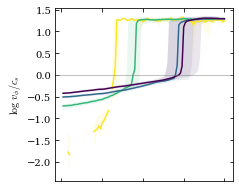

In [227]:
pl.figure(figsize=(7,7))
ax = pl.subplot(221)
med_and_std(log(vphis/cs))
pl.ylabel(r'$\log\ v_\phi/c_s$')
ax.xaxis.set_major_formatter(ticker.NullFormatter())
pl.axhline(0,lw=0.5,c='.5')
# ax = pl.subplot(222)
# med_and_std(log(nHs))
# pl.ylabel(r'$\log\ n_{\rm H}$')
# pl.legend(loc='upper left',ncol=2,frameon=False,columnspacing=0.5)
# ax.xaxis.set_major_formatter(ticker.NullFormatter())
# pl.subplot(223)
# med_and_std(log(nHTs))
# pl.ylabel(r'$\log\ n_{\rm H} T$')
# pl.xlabel(r'time [Gyr]')
# pl.subplot(224)
# med_and_std(log(Ks))
# pl.ylabel(r'$\log\ K$')
# pl.xlabel(r'time [Gyr]')